For this project you'll dig into a large amount of text and apply most of what you've covered in this unit and in the course so far.

First, pick a set of texts. This can be either a series of novels, chapters, or articles. Anything you'd like. It just has to have multiple entries of varying characteristics. At least 100 should be good. There should also be at least 10 different authors, but try to keep the texts related (either all on the same topic of from the same branch of literature - something to make classification a bit more difficult than obviously different subjects).

This capstone can be an extension of your NLP challenge if you wish to use the same corpus. If you found problems with that data set that limited your analysis, however, it may be worth using what you learned to choose a new corpus. Reserve 25% of your corpus as a test set.

The first technique is to create a series of clusters. Try several techniques and pick the one you think best represents your data. Make sure there is a narrative and reasoning around why you have chosen the given clusters. Are authors consistently grouped into the same cluster?

Next, perform some unsupervised feature generation and selection using the techniques covered in this unit and elsewhere in the course. Using those features then build models to attempt to classify your texts by author. Try different permutations of unsupervised and supervised techniques to see which combinations have the best performance.

Lastly return to your holdout group. Does your clustering on those members perform as you'd expect? Have your clusters remained stable or changed dramatically? What about your model? Is its performance consistent?

If there is a divergence in the relative stability of your model and your clusters, delve into why.

Your end result should be a write up of how clustering and modeling compare for classifying your texts. What are the advantages of each? Why would you want to use one over the other? Approximately 3-5 pages is a good length for your write up, and remember to include visuals to help tell your story!

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyLDAvis
import pyLDAvis.sklearn
import re
import seaborn as sns
import spacy
import warnings
from bokeh.io import output_notebook
from bokeh.layouts import row
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.palettes import Category10
from bokeh.plotting import figure, show
from bokeh.transform import factor_cmap
from collections import Counter
from gensim import corpora, models
from gensim.models.ldamodel import LdaModel
from nlp_help import LsaPlotting, eval_clusters, make_kmeans_clusters
from nlp_help import fit_and_predict
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, normalize, Normalizer
from sklearn.tree import DecisionTreeClassifier
from typing import Dict

# Display preferences.
%matplotlib inline
output_notebook()
pd.options.display.float_format = '{:.3f}'.format
pyLDAvis.enable_notebook()
sns.set_style('white')
warnings.filterwarnings("ignore", category=DeprecationWarning)
#    action='ignore',
#    module='scipy',
#    message='internal gelsd'
#)

/Users/danmchenry/miniconda3/lib/python3.7/site-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
/Users/danmchenry/miniconda3/lib/python3.7/site-packages/thinc/neural/train.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from .optimizers import Adam, SGD, linear_decay
/Users/danmchenry/miniconda3/lib/python3.7/site-packages/thinc/check.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import defaultdict, Sequence, Sized, Iterable, Callable
/Users/danmchenry/miniconda3/lib/python3.7/site-packages/thinc/check.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 

Loading BokehJS ...

# Data Cleaning, Processing, and Language Parsing

In [2]:
# Create lists for files and presidents.
files = ["1789-Washington.txt",
         "1801-Jefferson.txt",
         "1861-Lincoln.txt",
         "1933-Roosevelt.txt",
         "1953-Eisenhower.txt",
         "1961-Kennedy.txt",
         "1981-Reagan.txt",
         "1989-Bush.txt",
         "1993-Clinton.txt",
         "2009-Obama.txt"]

presidents = ["washington",
              "jefferson",
              "lincoln",
              "fdr",
              "eisenhower",
              "kennedy",
              "reagan",
              "ghwbush",
              "clinton",
              "obama"]

# Control to make sure both lists are the same length.
assert len(files) == len(presidents)

In [3]:
# Loop to open files.
docs = []
for file_name, president in zip(files, presidents):
    with open(f'./inaugural/{file_name}') as f:
        doc = f.read()
        docs.append((doc, president))

In [4]:
def text_cleaner(text: str) -> str:
    """Function to strip all characters except letters in words."""
    text = re.sub(r'--', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r"[\[].*?[\]]", "", text)
    text = re.sub(r"[\<].*?[\>]", "", text)
    text = ' '.join(text.split())
    return text

In [5]:
# Use text_cleaner on the docs, combine them into data frame (clean_docs).
clean_docs = []
for doc, pres in docs:
    clean_doc = text_cleaner(doc)
    clean_docs.append((clean_doc, pres))

In [6]:
# Iterate through each doc and print the first 100 characters for inspection.
for doc, pres in clean_docs:
    print(doc[:100], pres.upper()) 
    print()

Fellow-Citizens of the Senate and of the House of Representatives: Among the vicissitudes incident t WASHINGTON

Friends and Fellow Citizens: Called upon to undertake the duties of the first executive office of ou JEFFERSON

Fellow-Citizens of the United States: In compliance with a custom as old as the Government itself, I LINCOLN

I am certain that my fellow Americans expect that on my induction into the Presidency I will address FDR

My friends, before I begin the expression of those thoughts that I deem appropriate to this moment,  EISENHOWER

Vice President Johnson, Mr. Speaker, Mr. Chief Justice, President Eisenhower, Vice President Nixon,  KENNEDY

Senator Hatfield, Mr. Chief Justice, Mr. President, Vice President Bush, Vice President Mondale, Sen REAGAN

Mr. Chief Justice, Mr. President, Vice President Quayle, Senator Mitchell, Speaker Wright, Senator D GHWBUSH

My fellow citizens, today we celebrate the mystery of American renewal. This ceremony is held in the CLINTON

My fell

In [7]:
# Find number of characters in all docs.
print(len(clean_doc))

13334


In [8]:
# Define nlp as spacy.
nlp = spacy.load('en')
# Create an empty list for df.
df_list = []


def nlp_text(text_file: str) -> doc:
    """Function that takes a text file and tokenizes it with spacy."""
    return nlp(text_file)


def sentences(doc_nlp: str, speaker: str) -> [str, str]:
    """Function that takes two strings, lemmatizes the first string and 
    returns a list with two strings.
    """
    return [[sent.lemma_, speaker] for sent in doc_nlp.sents]


def sentences_to_df(sents):
    """Function that takes a string and returns a data frame."""
    return pd.DataFrame(sents)


# Calling each function.
for doc, pres in clean_docs:
    parsed = nlp_text(doc)
    sents = sentences(parsed, pres)
    df = sentences_to_df(sents)
    df_list.append(df)

In [9]:
# Combine each sentence data frame into one master data frame.
sent_df = pd.concat([*df_list])

In [10]:
# Rename columns.
sent_df.columns = ['sentence', 'President']

# Check the count of sents per President.
sent_df.President.value_counts()

ghwbush       145
lincoln       139
reagan        130
eisenhower    121
obama         113
fdr            86
clinton        82
kennedy        53
jefferson      42
washington     25
Name: President, dtype: int64

In [11]:
# Filter out pronouns from results.
sent_df['sentence'] = sent_df['sentence'].str.replace('-PRON-', '')

# Creating Features

In [12]:
# Splitting the data.
X = sent_df.sentence
y = sent_df.President
X_train_eval, X_holdout, y_train_eval, y_holdout = train_test_split(
    X, y, test_size=0.25, random_state=15)

In [13]:
# Splitting into train/eval/holdout groups.
X_train, X_eval, y_train, y_eval = train_test_split(
    X_train_eval, y_train_eval, test_size=0.25, random_state=15)

In [14]:
# Create base parameters dictionary.
base_param_dict = {'strip_accents': 'unicode',
                   'lowercase': True,
                   'stop_words': 'english',
                   'ngram_range': (1, 3),
                   'max_df': 0.5,
                   'min_df': 5,
                   'max_features': 1000}

## Count Vectorizer - Bag of Words (BoW)

In [15]:
# Instantiate CountVectorizer.
bow = CountVectorizer(**base_param_dict)
tf_vectorizer = CountVectorizer(**base_param_dict)

# Fit/transform document-term matrix.
dtm_tf = tf_vectorizer.fit_transform(X_train)
print(dtm_tf.shape)

(526, 231)


In [16]:
# Convert X_train, X_test into dfs of bags of words.
_bow_train = bow.fit_transform(X_train)
_bow_eval = bow.transform(X_eval)
_bow_holdout = bow.transform(X_holdout)
assert len(X_train) == _bow_train.shape[0]  # df and sparse-matrix

# Find feature names.
feature_names = bow.get_feature_names()

# Sparse matrix to data frame.
X_train_bow = pd.DataFrame(_bow_train.toarray(), columns=feature_names)
X_eval_bow = pd.DataFrame(_bow_eval.toarray(), columns=feature_names)
X_holdout_bow = pd.DataFrame(_bow_holdout.toarray(), columns=feature_names)

In [17]:
# Calculate weights on training data.
weights_bow = np.asarray(X_train_bow.sum(axis=0)).ravel()
weights_bow_df = pd.DataFrame(
    {'word': bow.get_feature_names(), 'cum_weight': weights_bow})
print("\nTrain Weights:\n", weights_bow_df.sort_values(
    by='cum_weight', ascending=False).head(10))

# # Calculate weights on eval data.
weights_bow_eval = np.asarray(X_eval_bow.sum(axis=0)).ravel()
weights_bow_eval_df = pd.DataFrame(
    {'word': bow.get_feature_names(), 'cum_weight': weights_bow_eval})
print("\nEval Weights:\n", weights_bow_eval_df.sort_values(
    by='cum_weight', ascending=False).head(10))


Train Weights:
            word  cum_weight
147      people          58
80   government          44
227       world          44
131      nation          39
120        make          37
121         man          35
206        time          33
79         good          32
72         free          31
81        great          29

Eval Weights:
            word  cum_weight
80   government          15
131      nation          14
81        great          14
135         new          13
147      people          12
74      freedom          11
227       world          11
226        work          10
3       america          10
194      states          10


## Tfidf

In [18]:
# Instantiate Tfidf Vectorizer.
tfidf = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf = tfidf.fit_transform(X_train)
print(dtm_tfidf.shape)

(526, 231)


/Users/danmchenry/miniconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:1616: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  UserWarning)


In [19]:
# Convert X_train, X_test into scipy sparse matrices of tfidf values.
_tfidf_train = tfidf.fit_transform(X_train)
_tfidf_eval = tfidf.transform(X_eval)
_tfidf_holdout = tfidf.transform(X_holdout)
assert len(X_train) == _tfidf_train.shape[0]  # df and sparse-matrix

# Find feature names.
feature_names_tfidf = tfidf.get_feature_names()

# Sparse matrix to data frames.
X_train_tfidf = pd.DataFrame(
    _tfidf_train.toarray(), columns=feature_names_tfidf)
X_eval_tfidf = pd.DataFrame(
    _tfidf_eval.toarray(), columns=feature_names_tfidf)
X_holdout_tfidf = pd.DataFrame(
    _tfidf_holdout.toarray(), columns=feature_names_tfidf)

/Users/danmchenry/miniconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:1616: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  UserWarning)


In [20]:
# Calculate weights on training data.
weights = np.asarray(X_train_tfidf.mean(axis=0)).ravel()
weights_df = pd.DataFrame(
    {'word': tfidf.get_feature_names(), 'avg_weight': weights})
print("\nTrain Weights:\n", weights_df.sort_values(
    by='avg_weight', ascending=False).head(10))

# Calculate weights on eval data.
weights = np.asarray(X_eval_tfidf.mean(axis=0)).ravel()
weights_df = pd.DataFrame(
    {'word': tfidf.get_feature_names(), 'avg_weight': weights})
print("\nEval Weights:\n", weights_df.sort_values(
    by='avg_weight', ascending=False).head(10))


Train Weights:
            word  avg_weight
147      people       0.032
227       world       0.028
80   government       0.028
131      nation       0.026
206        time       0.025
108         let       0.023
79         good       0.023
120        make       0.022
111        life       0.022
81        great       0.022

Eval Weights:
            word  avg_weight
135         new       0.029
226        work       0.029
81        great       0.028
74      freedom       0.027
132    national       0.027
194      states       0.025
131      nation       0.024
80   government       0.023
147      people       0.023
158   principle       0.023


## Latent Semantic Analysis (LSA) - Bag of Words (BoW)

In [21]:
# Reduce feature space to 100 features with SVD.
svd = TruncatedSVD(100)

# Make pipeline to run SVD and normalize results.
lsa_pipe = make_pipeline(svd, Normalizer( ))

# Fit with training data, transform test data.
X_train_bow_lsa = lsa_pipe.fit_transform(X_train_bow)
X_eval_bow_lsa = lsa_pipe.transform(X_eval_bow)
X_holdout_bow_lsa = lsa_pipe.transform(X_holdout_bow)

# Examine variance captured in reduced feature space.
variance_explained = svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print('Percent variance captured by components:', total_variance*100)

sent_by_component = pd.DataFrame(X_train_bow_lsa, index=X_train)

# Look at values from first 5 components.
for i in range(5):
    print('\nComponent {}:'.format(i))
    print(sent_by_component.loc[:, i].sort_values(ascending=False)[:5])

Percent variance captured by components: 82.7209058111168

Component 0:
sentence
equal and exact justice to all man , of whatev state or persuasion , religious or political ; peace , commerce , and honest friendship with all nation , entangle alliance with none ; the support of the state government in all  right , as the most competent administration for  domestic concern and the sure bulwark against antirepublican tendency ; the preservation of the general government in  whole constitutional vigor , as the sheet anchor of  peace at home and safety abroad ; a jealous care of the right of election by the people a mild and safe corrective of abuse which be lop by the sword of revolution where peaceable remedy be unprovided ; absolute acquiescence in the decision of the majority , the vital principle of republic , from which be no appeal but to force , the vital principle and immediate parent of despotism ; a well discipline militia ,  good reliance in peace and for the first moment of wa

In [22]:
bow_lsa_plots = LsaPlotting(X_train_lsa=X_train_bow_lsa, y_train=y_train,
                              X_eval_lsa=X_eval_bow_lsa, y_eval=y_eval)

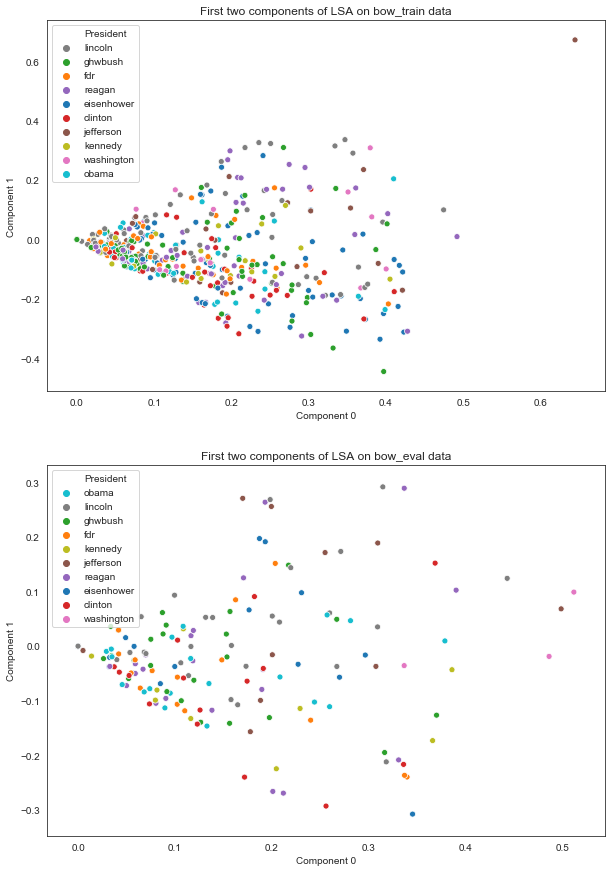

In [23]:
train_title_2d = 'First two components of LSA on bow_train data'
eval_title_2d = 'First two components of LSA on bow_eval data'

bow_lsa_plots.compare_plot_2d(train_title=train_title_2d,
                              eval_title=eval_title_2d)

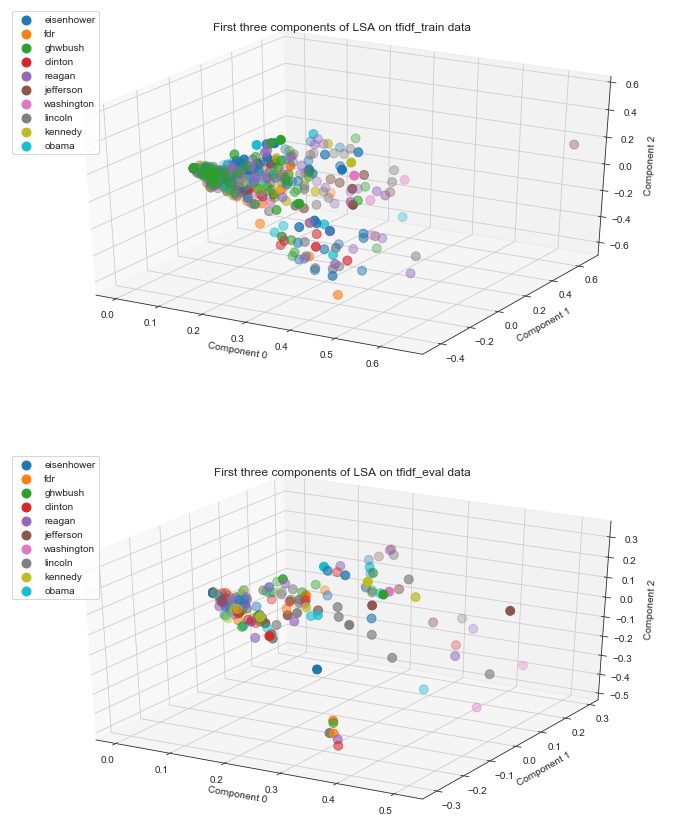

In [24]:
train_title_3d = 'First three components of LSA on tfidf_train data'
eval_title_3d = 'First three components of LSA on tfidf_eval data'

bow_lsa_plots.compare_plot_3d(train_title=train_title_3d,
                              eval_title=eval_title_3d)

In [25]:
bow_lsa_plots.compare_plot_interactive(X_train=X_train, X_eval=X_eval)

Loading BokehJS ...

## Latent Semantic Analysis (LSA) - Tfidf

In [26]:
# Fit with training data, transform test data.
X_train_lsa = lsa_pipe.fit_transform(X_train_tfidf)
X_eval_lsa = lsa_pipe.transform(X_eval_tfidf)
X_holdout_lsa = lsa_pipe.transform(X_holdout_tfidf)

# Examine variance captured in reduced feature space.
variance_explained = svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print('Percent variance captured by components:', total_variance*100)

sent_by_component = pd.DataFrame(X_train_lsa, index=X_train)

# Look at values from first 5 components.
for i in range(5):
    print('\nComponent {}:'.format(i))
    print(sent_by_component.loc[:, i].sort_values(ascending=False)[:5])

Percent variance captured by components: 74.9290907175306

Component 0:
sentence
 government have no power except that grant  by the people .                                                                                                                                                                                                                                                              0.432
to the people of poor nation ,  pledge to work alongside  to make  farm flourish and let clean water flow ; to nourish starve body and feed hungry mind .                                                                                                                                                                 0.421
americans deserve good , and in this city today there be people who want to do good , and so  say to all of  here , let  resolve to reform  politic , so that power and privilege no longer shout down the voice of the people .                                                       

In [27]:
tfidf_lsa_plots = LsaPlotting(X_train_lsa=X_train_lsa, y_train=y_train,
                              X_eval_lsa=X_eval_lsa, y_eval=y_eval)

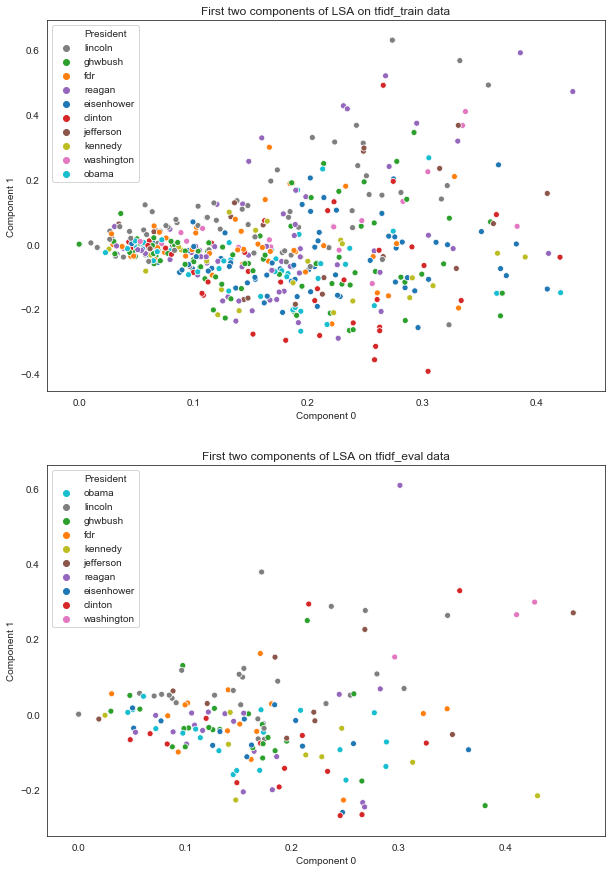

In [28]:
train_title_2d = 'First two components of LSA on tfidf_train data'
eval_title_2d = 'First two components of LSA on tfidf_eval data'

tfidf_lsa_plots.compare_plot_2d(train_title=train_title_2d,
                                eval_title=eval_title_2d)

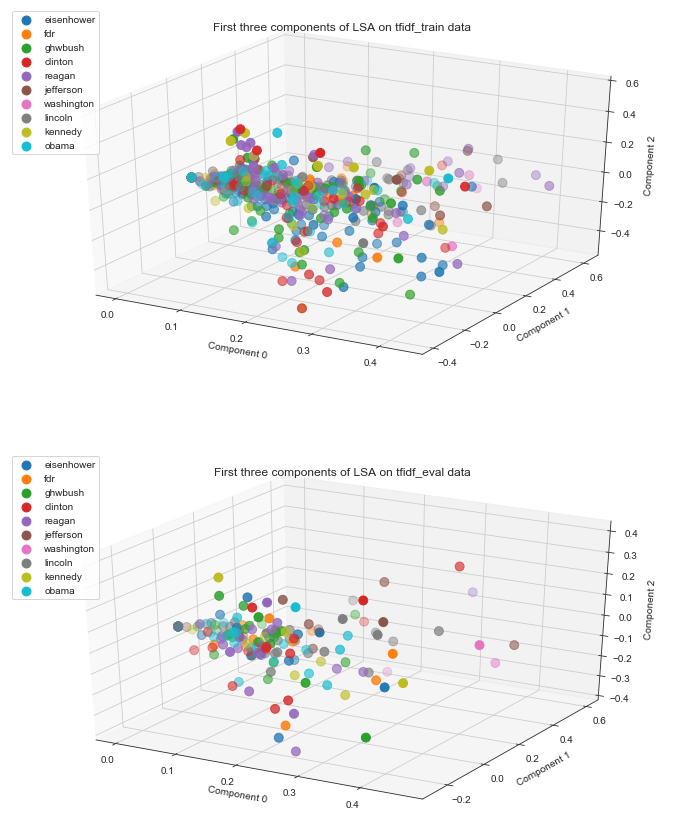

In [29]:
train_title_3d = 'First three components of LSA on tfidf_train data'
eval_title_3d = 'First three components of LSA on tfidf_eval data'

tfidf_lsa_plots.compare_plot_3d(train_title=train_title_3d,
                                eval_title=eval_title_3d)

In [30]:
tfidf_lsa_plots.compare_plot_interactive(X_train=X_train, X_eval=X_eval)

Loading BokehJS ...

# Clustering Models

## Clustering - BoW

In [31]:
# Make KMeans.
make_kmeans_clusters(X_train_bow)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=15, tol=0.0001, verbose=0)
Clusters 2	 silhoutte                     0.6579746817927677

KMeans col_0    0  1
row_0        
0      525  0
1        0  1 

MiniBatchKMeans(batch_size=500, compute_labels=True, init='random',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=2, n_init=3, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)
Clusters 2	 silhoutte                     0.15738087377503357

MiniBatch col_0   0    1
row_0         
0       1    0
1      76  449 

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=15, tol=0.0001, verbose=0)
Clusters 3	 silhoutte                     0.14332405731510417

KMeans col_0   0  1    2
row_0      

In [32]:
# Re-run KMeans and extract cluster information.
model_bow = KMeans(n_clusters=4, random_state=15).fit(X_train_bow)

# Extract cluster assignments for each data point.
labels = model_bow.labels_

In [33]:
eval_clusters(model_bow, X_train_bow, X_eval_bow, X_holdout_bow)

Train set aggregiated: 
            act  action  administration  america  american  american people  \
clusters                                                                     
0        0.038   0.000           0.000    0.038     0.000            0.000   
1        0.017   0.015           0.004    0.044     0.013            0.007   
2        0.069   0.000           0.103    0.000     0.069            0.069   
3        0.000   0.083           0.083    0.000     0.083            0.000   

          americans   ask  authority  balance  ...   way  willing  wish  \
clusters                                       ...                        
0             0.038 0.038      0.000    0.000  ... 0.000    0.000 0.038   
1             0.028 0.017      0.011    0.011  ... 0.015    0.011 0.009   
2             0.034 0.034      0.138    0.000  ... 0.034    0.000 0.000   
3             0.000 0.000      0.000    0.000  ... 0.000    0.000 0.000   

          woman  word  work  world  write  year  young 

## Clustering - Tfidf

In [34]:
# Make KMeans.
make_kmeans_clusters(X_train_tfidf) 

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=15, tol=0.0001, verbose=0)
Clusters 2	 silhoutte                     0.024038081526201075

KMeans col_0    0   1
row_0         
0      487   0
1        0  39 

MiniBatchKMeans(batch_size=500, compute_labels=True, init='random',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=2, n_init=3, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)
Clusters 2	 silhoutte                     0.02276503122834231

MiniBatch col_0    0   1
row_0         
0      408  91
1       26   1 

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=15, tol=0.0001, verbose=0)
Clusters 3	 silhoutte                     0.02577762272287257

KMeans col_0    0   1   2
row_

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=15, tol=0.0001, verbose=0)
Clusters 10	 silhoutte                     0.0387890509783065

KMeans col_0    0   1   2   3   4   5   6   7   8   9
row_0                                         
0      251   0   0   0   0   0   0   0   0   0
1        0  45   0   0   0   0   0   0   0   0
2        0   0  24   0   0   0   0   0   0   0
3        0   0   0  29   0   0   0   0   0   0
4        0   0   0   0  21   0   0   0   0   0
5        0   0   0   0   0  61   0   0   0   0
6        0   0   0   0   0   0  27   0   0   0
7        0   0   0   0   0   0   0  30   0   0
8        0   0   0   0   0   0   0   0  18   0
9        0   0   0   0   0   0   0   0   0  20 

MiniBatchKMeans(batch_size=500, compute_labels=True, init='random',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=10, n_in

In [35]:
# Re-run KMeans and extract cluster information.
model_tfidf = KMeans(n_clusters=5, random_state=15).fit(X_train_tfidf)

# Extract cluster assignments for each data point.
labels = model_tfidf.labels_

In [36]:
eval_clusters(model_tfidf, X_train_tfidf, X_eval_tfidf, X_holdout_tfidf)

Train set aggregiated: 
            act  action  administration  america  american  american people  \
clusters                                                                     
0        0.012   0.006           0.003    0.019     0.001            0.000   
1        0.000   0.015           0.000    0.024     0.021            0.000   
2        0.013   0.008           0.018    0.018     0.036            0.033   
3        0.000   0.000           0.000    0.008     0.009            0.000   
4        0.008   0.010           0.012    0.000     0.000            0.000   

          americans   ask  authority  balance  ...   way  willing  wish  \
clusters                                       ...                        
0             0.013 0.011      0.000    0.006  ... 0.004    0.001 0.003   
1             0.019 0.000      0.000    0.000  ... 0.054    0.014 0.000   
2             0.015 0.008      0.016    0.000  ... 0.000    0.010 0.008   
3             0.009 0.026      0.000    0.000  ... 0.

## Clustering - LSA (BoW)

In [37]:
# Make KMeans.
make_kmeans_clusters(X_train_bow_lsa)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=15, tol=0.0001, verbose=0)
Clusters 2	 silhoutte                     0.02659623375047682

KMeans col_0    0    1
row_0          
0      423    0
1        0  103 

MiniBatchKMeans(batch_size=500, compute_labels=True, init='random',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=2, n_init=3, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)
Clusters 2	 silhoutte                     0.014540824505051505

MiniBatch col_0    0    1
row_0          
0      205  130
1       45  146 

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=15, tol=0.0001, verbose=0)
Clusters 3	 silhoutte                     0.030557483028143366

KMeans col_0    0   1

Clusters 10	 silhoutte                     0.053240063363735705

KMeans col_0   0   1   2   3   4   5   6    7   8   9
row_0                                         
0      48   0   0   0   0   0   0    0   0   0
1       0  20   0   0   0   0   0    0   0   0
2       0   0  23   0   0   0   0    0   0   0
3       0   0   0  35   0   0   0    0   0   0
4       0   0   0   0  43   0   0    0   0   0
5       0   0   0   0   0  27   0    0   0   0
6       0   0   0   0   0   0  90    0   0   0
7       0   0   0   0   0   0   0  148   0   0
8       0   0   0   0   0   0   0    0  72   0
9       0   0   0   0   0   0   0    0   0  20 

MiniBatchKMeans(batch_size=500, compute_labels=True, init='random',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=10, n_init=3, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)
Clusters 10	 silhoutte                     0.04760415424832903

MiniBatch col_0   0   1   2   3   4   5 

In [38]:
# Re-run KMeans and extract cluster information.
model_bow_lsa = KMeans(n_clusters=4, random_state=15).fit(X_train_bow_lsa)

In [39]:
# Change np arrays to dfs, headings=col_names.
col_names = [f'comp_{i}' for i in range(X_train_bow_lsa.shape[1])]

_df_train = pd.DataFrame(X_train_bow_lsa, columns=col_names)
_df_eval = pd.DataFrame(X_eval_bow_lsa, columns=col_names)
_df_holdout = pd.DataFrame(X_eval_bow_lsa, columns=col_names)

eval_clusters(model_bow_lsa, _df_train, _df_eval, _df_holdout)

Train set aggregiated: 
           comp_0  comp_1  comp_2  comp_3  comp_4  comp_5  comp_6  comp_7  \
clusters                                                                   
0          0.112  -0.001   0.012   0.051  -0.012  -0.017   0.021   0.001   
1          0.170  -0.044  -0.004   0.004  -0.186   0.038   0.155   0.178   
2          0.350  -0.144  -0.305  -0.107   0.086   0.066  -0.111   0.052   
3          0.170  -0.110   0.100  -0.078  -0.085  -0.109   0.021  -0.052   

          comp_8  comp_9  ...  comp_90  comp_91  comp_92  comp_93  comp_94  \
clusters                  ...                                                
0          0.015  -0.024  ...    0.003   -0.009    0.005   -0.000   -0.002   
1         -0.200   0.009  ...   -0.007    0.011    0.010    0.010   -0.006   
2          0.037   0.067  ...   -0.004    0.003   -0.004    0.000    0.000   
3          0.013  -0.019  ...    0.001    0.019    0.006    0.007   -0.005   

          comp_95  comp_96  comp_97  comp_98  com

## Clustering - LSA (Tfidf)

In [40]:
# Make KMeans.
make_kmeans_clusters(X_train_lsa)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=15, tol=0.0001, verbose=0)
Clusters 2	 silhoutte                     0.019286453724048344

KMeans col_0    0    1
row_0          
0      354    0
1        0  172 

MiniBatchKMeans(batch_size=500, compute_labels=True, init='random',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=2, n_init=3, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)
Clusters 2	 silhoutte                     0.018836516990831532

MiniBatch col_0    0    1
row_0          
0       57  164
1      131  174 

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=15, tol=0.0001, verbose=0)
Clusters 3	 silhoutte                     0.020652733189383023

KMeans col_0    0   

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=15, tol=0.0001, verbose=0)
Clusters 10	 silhoutte                     0.050857045449815425

KMeans col_0   0   1   2   3   4   5   6   7   8    9
row_0                                         
0      28   0   0   0   0   0   0   0   0    0
1       0  27   0   0   0   0   0   0   0    0
2       0   0  50   0   0   0   0   0   0    0
3       0   0   0  69   0   0   0   0   0    0
4       0   0   0   0  13   0   0   0   0    0
5       0   0   0   0   0  39   0   0   0    0
6       0   0   0   0   0   0  22   0   0    0
7       0   0   0   0   0   0   0  44   0    0
8       0   0   0   0   0   0   0   0  22    0
9       0   0   0   0   0   0   0   0   0  212 

MiniBatchKMeans(batch_size=500, compute_labels=True, init='random',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=10, n_

In [41]:
# Re-run KMeans and extract cluster information.
model_lsa = KMeans(n_clusters=4, random_state=15).fit(X_train_lsa)

In [42]:
# Change np arrays to dfs, headings=col_names.
_df_train = pd.DataFrame(X_train_lsa, columns=col_names)
_df_eval = pd.DataFrame(X_eval_lsa, columns=col_names)
_df_holdout = pd.DataFrame(X_eval_lsa, columns=col_names)

eval_clusters(model_lsa, _df_train, _df_eval, _df_holdout)

Train set aggregiated: 
           comp_0  comp_1  comp_2  comp_3  comp_4  comp_5  comp_6  comp_7  \
clusters                                                                   
0          0.172  -0.036   0.184   0.006  -0.098   0.396   0.227  -0.173   
1          0.144  -0.014   0.020  -0.021  -0.013   0.006  -0.010   0.013   
2          0.298   0.113  -0.102   0.079   0.239  -0.095   0.048  -0.047   
3          0.199  -0.232  -0.189   0.152  -0.278  -0.098   0.045  -0.116   

          comp_8  comp_9  ...  comp_90  comp_91  comp_92  comp_93  comp_94  \
clusters                  ...                                                
0         -0.163   0.144  ...   -0.005    0.002   -0.000   -0.009   -0.001   
1          0.032  -0.013  ...    0.000    0.001   -0.002   -0.003    0.001   
2         -0.057   0.111  ...    0.001    0.001    0.001    0.008   -0.003   
3          0.048  -0.195  ...   -0.003    0.020    0.036    0.015    0.017   

          comp_95  comp_96  comp_97  comp_98  com

## Clustering - Latent Dirichlet Allocation (LDA)

In [43]:
# For TF DTM == BoW.
lda_tf = LatentDirichletAllocation(n_components=4, random_state=15)
lda_tf.fit(dtm_tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=4, n_jobs=None,
                          perp_tol=0.1, random_state=15, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [44]:
# For TFIDF DTM.
lda_tfidf = LatentDirichletAllocation(n_components=5, random_state=15)
lda_tfidf.fit(dtm_tfidf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=15, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

## Visualizing the Models With pyLDAvis

In [45]:
# Prepare pyLDAvis model.
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)

/Users/danmchenry/miniconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=           x      y  topics  cluster   Freq
topic                                      
2      0.026 -0.045       1        1 32.443
3     -0.207 -0.073       2        1 25.209
0      0.171 -0.095       3        1 22.451
1      0.010  0.213       4        1 19.897, topic_info=    Category   Freq        Term  Total  loglift  logprob
227  Default 40.000       world 40.000   30.000   30.000
72   Default 28.000        free 28.000   29.000   29.000
68   Default 19.000      fellow 19.000   28.000   28.000
79   Default 29.000        good 29.000   27.000   27.000
3    Default 19.000     america 19.000   26.000   26.000
..       ...    ...         ...    ...      ...      ...
74    Topic4  6.464     freedom 20.920    0.440   -4.260
121   Topic4  6.556         man 32.683    0.008   -4.246
48    Topic4  5.372        duty 12.803    0.746   -4.445
225   Topic4  5.414        word 15.482    0.564   -4.438
80    Topic4  5.168  government 40.868   -0.453   -4.484

[199 rows x 6 columns], token_table=      Topic  Freq      Term
term                       
0         3 0.916       act
1         3 0.730    action
1         4 0.243    action
3         2 0.956   america
4         2 0.110  american
...     ...   ...       ...
225       4 0.323      word
226       1 0.150      work
226       3 0.850      work
227       1 0.025     world
227       2 0.959     world

[267 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 1, 2])

In [46]:
pyLDAvis.sklearn.prepare(lda_tfidf, dtm_tfidf, tfidf)

/Users/danmchenry/miniconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=           x      y  topics  cluster   Freq
topic                                      
2      0.072 -0.070       1        1 25.452
3      0.133  0.027       2        1 20.685
0     -0.138 -0.124       3        1 19.346
4     -0.111  0.149       4        1 17.261
1      0.044  0.019       5        1 17.255, topic_info=    Category   Freq        Term  Total  loglift  logprob
227  Default 12.000       world 12.000   30.000   30.000
42   Default  9.000         day  9.000   29.000   29.000
177  Default  8.000       right  8.000   28.000   28.000
79   Default 10.000        good 10.000   27.000   27.000
83   Default  7.000        hand  7.000   26.000   26.000
..       ...    ...         ...    ...      ...      ...
108   Topic5  2.826         let 10.764    0.420   -4.083
181   Topic5  1.889         say  4.252    0.945   -4.486
103   Topic5  1.953        land  5.360    0.747   -4.452
81    Topic5  2.080       great  9.896    0.198   -4.389
80    Topic5  2.103  government 12.766   -0.047   -4.378

[227 rows x 6 columns], token_table=      Topic  Freq            Term
term                             
0         5 0.776             act
1         3 0.276          action
1         5 0.552          action
2         1 0.715  administration
3         2 0.733         america
...     ...   ...             ...
228       1 0.287           write
228       3 0.287           write
228       5 0.574           write
230       3 0.638           young
230       5 0.319           young

[326 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 1, 5, 2])

In [47]:
pyLDAvis.sklearn.prepare(
    lda_tf, dtm_tf, tf_vectorizer, mds='mmds')

/Users/danmchenry/miniconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=           x      y  topics  cluster   Freq
topic                                      
2     -0.166 -0.117       1        1 32.443
3     -0.129  0.192       2        1 25.209
0      0.126 -0.187       3        1 22.451
1      0.168  0.112       4        1 19.897, topic_info=    Category   Freq        Term  Total  loglift  logprob
227  Default 40.000       world 40.000   30.000   30.000
72   Default 28.000        free 28.000   29.000   29.000
68   Default 19.000      fellow 19.000   28.000   28.000
79   Default 29.000        good 29.000   27.000   27.000
3    Default 19.000     america 19.000   26.000   26.000
..       ...    ...         ...    ...      ...      ...
74    Topic4  6.464     freedom 20.920    0.440   -4.260
121   Topic4  6.556         man 32.683    0.008   -4.246
48    Topic4  5.372        duty 12.803    0.746   -4.445
225   Topic4  5.414        word 15.482    0.564   -4.438
80    Topic4  5.168  government 40.868   -0.453   -4.484

[199 rows x 6 columns], token_table=      Topic  Freq      Term
term                       
0         3 0.916       act
1         3 0.730    action
1         4 0.243    action
3         2 0.956   america
4         2 0.110  american
...     ...   ...       ...
225       4 0.323      word
226       1 0.150      work
226       3 0.850      work
227       1 0.025     world
227       2 0.959     world

[267 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 1, 2])

In [48]:
pyLDAvis.sklearn.prepare(
    lda_tf, dtm_tf, tf_vectorizer, mds='tsne')

/Users/danmchenry/miniconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=            x        y  topics  cluster   Freq
topic                                         
2     112.095 -399.838       1        1 32.443
3     218.417 -376.958       2        1 25.209
0      89.212 -293.516       3        1 22.451
1     195.534 -270.636       4        1 19.897, topic_info=    Category   Freq        Term  Total  loglift  logprob
227  Default 40.000       world 40.000   30.000   30.000
72   Default 28.000        free 28.000   29.000   29.000
68   Default 19.000      fellow 19.000   28.000   28.000
79   Default 29.000        good 29.000   27.000   27.000
3    Default 19.000     america 19.000   26.000   26.000
..       ...    ...         ...    ...      ...      ...
74    Topic4  6.464     freedom 20.920    0.440   -4.260
121   Topic4  6.556         man 32.683    0.008   -4.246
48    Topic4  5.372        duty 12.803    0.746   -4.445
225   Topic4  5.414        word 15.482    0.564   -4.438
80    Topic4  5.168  government 40.868   -0.453   -4.484

[199 rows x 6 columns], token_table=      Topic  Freq      Term
term                       
0         3 0.916       act
1         3 0.730    action
1         4 0.243    action
3         2 0.956   america
4         2 0.110  american
...     ...   ...       ...
225       4 0.323      word
226       1 0.150      work
226       3 0.850      work
227       1 0.025     world
227       2 0.959     world

[267 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 1, 2])

### Run LDA

In [49]:
# texts = sent_df['sentence_tokens']
# dictionary = corpora.Dictionary(texts)
# corpus = [dictionary.doc2bow(text) for text in texts]
# lda = LdaModel(corpus,
#                id2word=dictionary,
#                num_topics=10,
#                passes=5,
#                minimum_probability=0,
#                random_state=15)

In [50]:
# # Print topics
# lda.print_topics()

In [51]:
# # Refactoring results of LDA into numpy matrix.
# hm = np.array([[y for (x,y) in lda[corpus[i]]] for i in range(len(corpus))])

In [52]:
# # Reduce dimensionality using t-SNE.
# tsne = TSNE(random_state=15, perplexity=30, early_exaggeration=120)
# embedding = tsne.fit_transform(hm)
# embedding = pd.DataFrame(embedding, columns=['x','y'])
# embedding['hue'] = hm.argmax(axis=1)

# Prepare for Predictive Modeling

In [53]:
print('Baseline score to beat:', sum(
    (sent_df.President == 'ghwbush') / len(sent_df.President)))

Baseline score to beat: 0.15491452991452967


In [54]:
# Pipeline helpers.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=15)

In [55]:
# Instantiate the models.
log_reg = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=15)
tree = DecisionTreeClassifier(random_state=15)
forest = RandomForestClassifier(max_depth=10, random_state=15)
boost = GradientBoostingClassifier(random_state=15)
nb = BernoulliNB()

In [56]:
# Set up _kwargs files for convenience.
bow_kwargs = {'X_train': X_train_bow, 'y_train': y_train,
              'X_eval': X_eval_bow, 'y_eval': y_eval}

tfidf_kwargs = {'X_train': X_train_tfidf,'y_train': y_train,
                'X_eval': X_eval_tfidf,'y_eval': y_eval}

bow_lsa_kwargs = {'X_train': X_train_bow_lsa, 'y_train': y_train,
              'X_eval': X_eval_bow_lsa, 'y_eval': y_eval}

tfidf_lsa_kwargs = {'X_train': X_train_lsa, 'y_train': y_train,
              'X_eval': X_eval_lsa, 'y_eval': y_eval}

In [57]:
# Tune parameter grids.
log_reg_params = {'model__C': [1, 10, 100, 1000]}
tree_params = {'model__criterion': ['gini']}
forest_params = {'model__n_estimators': [100, 200, 300,400],
                 'model__max_depth': [None, 5, 10]}
boost_params = {'model__n_estimators': [100]}
nb_params = {'model__alpha': [1]}

## Logistic Regression

### Bag of Words

In [58]:
fit_and_predict(log_reg, params=log_reg_params, **bow_kwargs)

The mean cross_val accuracy on train is [0.3460076  0.31558935 0.29277567 0.29087452].
The std of the cross_val accuracy is [0.03885721 0.0330231  0.05219954 0.06938754].
              precision    recall  f1-score   support

     clinton       0.33      0.12      0.18        16
  eisenhower       0.30      0.37      0.33        19
         fdr       0.29      0.12      0.17        16
     ghwbush       0.16      0.40      0.23        25
   jefferson       0.50      0.10      0.17        10
     kennedy       0.00      0.00      0.00         9
     lincoln       0.63      0.59      0.61        29
       obama       0.14      0.04      0.06        25
      reagan       0.32      0.54      0.40        24
  washington       1.00      0.33      0.50         3

    accuracy                           0.31       176
   macro avg       0.37      0.26      0.27       176
weighted avg       0.33      0.31      0.28       176

[[ 2  2  0  8  0  1  0  0  3  0]
 [ 0  7  0  8  0  0  1  2  1  0]
 [ 0

/Users/danmchenry/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


### Tfidf

In [59]:
fit_and_predict(log_reg, params=log_reg_params, **tfidf_kwargs)

/Users/danmchenry/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


The mean cross_val accuracy on train is [0.32319392 0.34410646 0.30608365 0.29087452].
The std of the cross_val accuracy is [0.03478015 0.03823611 0.05419021 0.06813385].
              precision    recall  f1-score   support

     clinton       0.50      0.25      0.33        16
  eisenhower       0.26      0.32      0.29        19
         fdr       0.36      0.25      0.30        16
     ghwbush       0.13      0.28      0.18        25
   jefferson       0.40      0.20      0.27        10
     kennedy       0.25      0.11      0.15         9
     lincoln       0.69      0.62      0.65        29
       obama       0.11      0.04      0.06        25
      reagan       0.37      0.54      0.44        24
  washington       1.00      0.33      0.50         3

    accuracy                           0.32       176
   macro avg       0.41      0.29      0.32       176
weighted avg       0.36      0.32      0.32       176

[[ 4  3  0  7  0  0  0  0  2  0]
 [ 0  6  0  9  0  0  0  3  1  0]
 [ 1

### LSA - BoW

In [60]:
fit_and_predict(log_reg, params=log_reg_params, **bow_lsa_kwargs)

The mean cross_val accuracy on train is [0.33460076 0.33460076 0.32129278 0.30798479].
The std of the cross_val accuracy is [0.04356602 0.04797862 0.04197747 0.04594851].
              precision    recall  f1-score   support

     clinton       0.20      0.12      0.15        16
  eisenhower       0.35      0.47      0.40        19
         fdr       0.20      0.06      0.10        16
     ghwbush       0.15      0.36      0.21        25
   jefferson       1.00      0.10      0.18        10
     kennedy       0.50      0.11      0.18         9
     lincoln       0.54      0.69      0.61        29
       obama       0.17      0.04      0.06        25
      reagan       0.25      0.29      0.27        24
  washington       0.00      0.00      0.00         3

    accuracy                           0.29       176
   macro avg       0.34      0.23      0.22       176
weighted avg       0.32      0.29      0.26       176

[[ 2  1  1  7  0  1  0  1  3  0]
 [ 0  9  0  7  0  0  0  1  2  0]
 [ 0

/Users/danmchenry/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/danmchenry/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### LSA - Tfidf

In [61]:
fit_and_predict(log_reg, params=log_reg_params, **tfidf_lsa_kwargs)

The mean cross_val accuracy on train is [0.3365019  0.3269962  0.31178707 0.30038023].
The std of the cross_val accuracy is [0.03491064 0.02968645 0.03155018 0.03450218].
              precision    recall  f1-score   support

     clinton       0.22      0.12      0.16        16
  eisenhower       0.38      0.47      0.42        19
         fdr       0.14      0.06      0.09        16
     ghwbush       0.14      0.36      0.20        25
   jefferson       1.00      0.10      0.18        10
     kennedy       0.00      0.00      0.00         9
     lincoln       0.54      0.69      0.61        29
       obama       0.25      0.04      0.07        25
      reagan       0.25      0.29      0.27        24
  washington       0.00      0.00      0.00         3

    accuracy                           0.28       176
   macro avg       0.29      0.21      0.20       176
weighted avg       0.31      0.28      0.25       176

[[ 2  1  1  9  0  1  0  0  2  0]
 [ 0  9  1  6  0  0  1  1  1  0]
 [ 0

/Users/danmchenry/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/danmchenry/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Decision Trees

### Bag of Words

In [62]:
fit_and_predict(tree, params=tree_params, **bow_kwargs)

The mean cross_val accuracy on train is [0.29277567].
The std of the cross_val accuracy is [0.03499675].
              precision    recall  f1-score   support

     clinton       0.26      0.38      0.31        16
  eisenhower       0.17      0.16      0.16        19
         fdr       0.36      0.31      0.33        16
     ghwbush       0.14      0.32      0.19        25
   jefferson       0.50      0.10      0.17        10
     kennedy       0.00      0.00      0.00         9
     lincoln       0.62      0.52      0.57        29
       obama       0.11      0.04      0.06        25
      reagan       0.29      0.25      0.27        24
  washington       0.50      0.67      0.57         3

    accuracy                           0.27       176
   macro avg       0.29      0.27      0.26       176
weighted avg       0.29      0.27      0.26       176

[[ 6  1  0  7  0  0  0  2  0  0]
 [ 1  3  0  9  0  1  2  0  3  0]
 [ 2  1  5  5  0  0  0  1  2  0]
 [ 4  5  2  8  0  0  1  1  4  0]
 [ 1

### Tfidf

In [63]:
fit_and_predict(tree, params=tree_params, **tfidf_kwargs)

The mean cross_val accuracy on train is [0.26996198].
The std of the cross_val accuracy is [0.02481034].
              precision    recall  f1-score   support

     clinton       0.25      0.25      0.25        16
  eisenhower       0.18      0.32      0.23        19
         fdr       0.19      0.19      0.19        16
     ghwbush       0.14      0.28      0.18        25
   jefferson       0.00      0.00      0.00        10
     kennedy       0.25      0.11      0.15         9
     lincoln       0.55      0.41      0.47        29
       obama       0.23      0.12      0.16        25
      reagan       0.41      0.29      0.34        24
  washington       0.00      0.00      0.00         3

    accuracy                           0.24       176
   macro avg       0.22      0.20      0.20       176
weighted avg       0.27      0.24      0.25       176

[[ 4  2  0  5  0  0  0  3  2  0]
 [ 1  6  2  8  0  0  1  0  1  0]
 [ 0  3  3  6  1  0  0  1  2  0]
 [ 3  6  2  7  1  0  3  2  0  1]
 [ 0

### LSA - BoW

In [64]:
fit_and_predict(tree, params=tree_params, **bow_lsa_kwargs)

The mean cross_val accuracy on train is [0.19011407].
The std of the cross_val accuracy is [0.04925833].
              precision    recall  f1-score   support

     clinton       0.11      0.06      0.08        16
  eisenhower       0.22      0.21      0.22        19
         fdr       0.21      0.31      0.25        16
     ghwbush       0.13      0.20      0.16        25
   jefferson       0.14      0.10      0.12        10
     kennedy       0.14      0.11      0.12         9
     lincoln       0.29      0.24      0.26        29
       obama       0.12      0.08      0.10        25
      reagan       0.19      0.21      0.20        24
  washington       0.00      0.00      0.00         3

    accuracy                           0.18       176
   macro avg       0.16      0.15      0.15       176
weighted avg       0.18      0.18      0.17       176

[[1 3 3 3 0 2 1 3 0 0]
 [1 4 1 9 0 0 1 0 2 1]
 [2 0 5 2 1 0 1 2 3 0]
 [2 4 1 5 1 1 2 3 5 1]
 [0 1 1 1 1 1 3 0 2 0]
 [0 0 0 1 0 1 2 4 0 1

### LSA - Tfidf

In [65]:
fit_and_predict(tree, params=tree_params, **tfidf_lsa_kwargs)

The mean cross_val accuracy on train is [0.22053232].
The std of the cross_val accuracy is [0.06564517].
              precision    recall  f1-score   support

     clinton       0.12      0.06      0.08        16
  eisenhower       0.17      0.21      0.19        19
         fdr       0.27      0.25      0.26        16
     ghwbush       0.15      0.28      0.19        25
   jefferson       0.00      0.00      0.00        10
     kennedy       0.33      0.22      0.27         9
     lincoln       0.30      0.31      0.31        29
       obama       0.14      0.08      0.10        25
      reagan       0.05      0.04      0.04        24
  washington       0.33      0.67      0.44         3

    accuracy                           0.18       176
   macro avg       0.19      0.21      0.19       176
weighted avg       0.17      0.18      0.17       176

[[ 1  1  2  5  0  1  2  4  0  0]
 [ 0  4  1  8  1  1  2  1  1  0]
 [ 2  0  4  2  0  0  3  1  3  1]
 [ 1  6  2  7  0  0  3  1  5  0]
 [ 0

## Random Forest

### Bag of Words

In [66]:
fit_and_predict(forest, params=forest_params, **bow_kwargs)

The mean cross_val accuracy on train is [0.32509506 0.32319392 0.32319392 0.32319392 0.28707224 0.28707224
 0.2756654  0.27376426 0.32129278 0.32129278 0.31939163 0.32509506].
The std of the cross_val accuracy is [0.02941448 0.02956775 0.03065402 0.03220988 0.02685105 0.03022755
 0.03270845 0.03813436 0.02777317 0.02981784 0.03038759 0.03394198].
              precision    recall  f1-score   support

     clinton       0.26      0.38      0.31        16
  eisenhower       0.29      0.32      0.30        19
         fdr       0.31      0.25      0.28        16
     ghwbush       0.15      0.28      0.19        25
   jefferson       0.75      0.30      0.43        10
     kennedy       0.00      0.00      0.00         9
     lincoln       0.63      0.59      0.61        29
       obama       0.10      0.04      0.06        25
      reagan       0.32      0.38      0.35        24
  washington       0.00      0.00      0.00         3

    accuracy                           0.30       176
 

/Users/danmchenry/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Tfidf

In [67]:
fit_and_predict(forest, params=forest_params, **tfidf_kwargs)

The mean cross_val accuracy on train is [0.32509506 0.33460076 0.32509506 0.32509506 0.28136882 0.28136882
 0.27946768 0.28136882 0.30608365 0.29847909 0.30798479 0.30608365].
The std of the cross_val accuracy is [0.03719553 0.03256402 0.03495425 0.02959661 0.03625646 0.04386773
 0.04103643 0.0480696  0.04262845 0.0340082  0.03723597 0.03638472].
              precision    recall  f1-score   support

     clinton       0.24      0.25      0.24        16
  eisenhower       0.21      0.32      0.26        19
         fdr       0.27      0.19      0.22        16
     ghwbush       0.15      0.28      0.20        25
   jefferson       0.43      0.30      0.35        10
     kennedy       0.50      0.11      0.18         9
     lincoln       0.53      0.55      0.54        29
       obama       0.07      0.04      0.05        25
      reagan       0.33      0.29      0.31        24
  washington       0.00      0.00      0.00         3

    accuracy                           0.27       176
 

/Users/danmchenry/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### LSA - BoW

In [68]:
fit_and_predict(forest, params=forest_params, **bow_lsa_kwargs)

The mean cross_val accuracy on train is [0.31939163 0.32129278 0.3269962  0.31939163 0.30038023 0.29847909
 0.30798479 0.31749049 0.34220532 0.33079848 0.33079848 0.33269962].
The std of the cross_val accuracy is [0.0353374  0.04192961 0.03499994 0.04072692 0.05699179 0.06774606
 0.06633324 0.05588613 0.04329276 0.04814738 0.04064549 0.04645961].
              precision    recall  f1-score   support

     clinton       0.43      0.19      0.26        16
  eisenhower       0.26      0.47      0.33        19
         fdr       0.33      0.06      0.11        16
     ghwbush       0.16      0.40      0.23        25
   jefferson       0.00      0.00      0.00        10
     kennedy       1.00      0.11      0.20         9
     lincoln       0.53      0.69      0.60        29
       obama       0.00      0.00      0.00        25
      reagan       0.22      0.25      0.24        24
  washington       0.00      0.00      0.00         3

    accuracy                           0.28       176
 

/Users/danmchenry/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### LSA - Tfidf

In [69]:
fit_and_predict(forest, params=forest_params, **tfidf_lsa_kwargs)

The mean cross_val accuracy on train is [0.31939163 0.32129278 0.33269962 0.32509506 0.28707224 0.29277567
 0.30418251 0.30608365 0.31178707 0.32129278 0.32509506 0.3365019 ].
The std of the cross_val accuracy is [0.03527405 0.04173602 0.04207491 0.03709753 0.05201429 0.05173242
 0.054381   0.04800052 0.0415487  0.04504617 0.04170771 0.04936667].
              precision    recall  f1-score   support

     clinton       0.40      0.12      0.19        16
  eisenhower       0.28      0.47      0.35        19
         fdr       0.33      0.06      0.11        16
     ghwbush       0.16      0.40      0.22        25
   jefferson       0.00      0.00      0.00        10
     kennedy       0.00      0.00      0.00         9
     lincoln       0.51      0.62      0.56        29
       obama       0.17      0.04      0.06        25
      reagan       0.23      0.29      0.25        24
  washington       0.00      0.00      0.00         3

    accuracy                           0.27       176
 

/Users/danmchenry/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Gradient Boosting Machines

### Bag of Words

In [70]:
fit_and_predict(boost, params=boost_params, **bow_kwargs)

The mean cross_val accuracy on train is [0.31558935].
The std of the cross_val accuracy is [0.02833728].
              precision    recall  f1-score   support

     clinton       0.31      0.25      0.28        16
  eisenhower       0.19      0.21      0.20        19
         fdr       0.25      0.12      0.17        16
     ghwbush       0.19      0.52      0.27        25
   jefferson       0.20      0.10      0.13        10
     kennedy       0.33      0.11      0.17         9
     lincoln       0.54      0.45      0.49        29
       obama       0.25      0.08      0.12        25
      reagan       0.30      0.29      0.30        24
  washington       0.00      0.00      0.00         3

    accuracy                           0.27       176
   macro avg       0.26      0.21      0.21       176
weighted avg       0.29      0.27      0.26       176

[[ 4  2  0  8  0  1  0  0  1  0]
 [ 0  4  1  9  0  0  1  2  2  0]
 [ 0  2  2  8  1  0  0  0  3  0]
 [ 2  4  1 13  0  0  2  1  2  0]
 [ 0

### Tfidf

In [71]:
fit_and_predict(boost, params=boost_params, **tfidf_kwargs)

The mean cross_val accuracy on train is [0.30038023].
The std of the cross_val accuracy is [0.03885476].
              precision    recall  f1-score   support

     clinton       0.36      0.25      0.30        16
  eisenhower       0.23      0.32      0.27        19
         fdr       0.27      0.19      0.22        16
     ghwbush       0.15      0.40      0.22        25
   jefferson       0.12      0.10      0.11        10
     kennedy       0.00      0.00      0.00         9
     lincoln       0.57      0.41      0.48        29
       obama       0.00      0.00      0.00        25
      reagan       0.30      0.25      0.27        24
  washington       0.00      0.00      0.00         3

    accuracy                           0.24       176
   macro avg       0.20      0.19      0.19       176
weighted avg       0.25      0.24      0.23       176

[[ 4  3  0  7  0  0  0  0  2  0]
 [ 0  6  1  6  1  1  1  2  1  0]
 [ 0  0  3  8  1  0  0  1  3  0]
 [ 1  5  2 10  0  1  2  2  2  0]
 [ 0

### LSA - BoW

In [72]:
fit_and_predict(boost, params=boost_params, **bow_lsa_kwargs)

The mean cross_val accuracy on train is [0.26996198].
The std of the cross_val accuracy is [0.05384434].
              precision    recall  f1-score   support

     clinton       0.17      0.06      0.09        16
  eisenhower       0.36      0.47      0.41        19
         fdr       0.00      0.00      0.00        16
     ghwbush       0.13      0.28      0.17        25
   jefferson       0.50      0.10      0.17        10
     kennedy       0.33      0.11      0.17         9
     lincoln       0.58      0.62      0.60        29
       obama       0.29      0.08      0.12        25
      reagan       0.18      0.25      0.21        24
  washington       0.00      0.00      0.00         3

    accuracy                           0.26       176
   macro avg       0.25      0.20      0.19       176
weighted avg       0.28      0.26      0.24       176

[[ 1  2  0  7  0  0  2  1  3  0]
 [ 0  9  0  6  0  0  1  0  3  0]
 [ 0  1  0  6  0  0  1  1  3  4]
 [ 2  4  1  7  1  0  5  1  3  1]
 [ 0

### LSA - Tfidf

In [73]:
fit_and_predict(boost, params=boost_params, **tfidf_lsa_kwargs)

The mean cross_val accuracy on train is [0.31558935].
The std of the cross_val accuracy is [0.07943006].
              precision    recall  f1-score   support

     clinton       0.00      0.00      0.00        16
  eisenhower       0.26      0.26      0.26        19
         fdr       0.14      0.06      0.09        16
     ghwbush       0.10      0.20      0.13        25
   jefferson       0.50      0.20      0.29        10
     kennedy       0.50      0.11      0.18         9
     lincoln       0.46      0.59      0.52        29
       obama       0.11      0.04      0.06        25
      reagan       0.16      0.21      0.18        24
  washington       0.00      0.00      0.00         3

    accuracy                           0.21       176
   macro avg       0.22      0.17      0.17       176
weighted avg       0.22      0.21      0.20       176

[[ 0  2  1  9  0  0  1  0  3  0]
 [ 2  5  0  7  0  0  1  0  4  0]
 [ 0  2  1  5  0  0  3  0  4  1]
 [ 3  3  1  5  1  0  7  0  4  1]
 [ 0

## Naive Bayes

### Bag of Words

In [74]:
fit_and_predict(nb, params=nb_params, **bow_kwargs)

The mean cross_val accuracy on train is [0.34410646].
The std of the cross_val accuracy is [0.02687473].
              precision    recall  f1-score   support

     clinton       0.00      0.00      0.00        16
  eisenhower       0.50      0.37      0.42        19
         fdr       0.40      0.12      0.19        16
     ghwbush       0.21      0.68      0.32        25
   jefferson       0.00      0.00      0.00        10
     kennedy       0.00      0.00      0.00         9
     lincoln       0.68      0.59      0.63        29
       obama       0.00      0.00      0.00        25
      reagan       0.24      0.42      0.31        24
  washington       1.00      0.33      0.50         3

    accuracy                           0.31       176
   macro avg       0.30      0.25      0.24       176
weighted avg       0.28      0.31      0.26       176

[[ 0  1  0 11  0  0  0  1  3  0]
 [ 0  7  0  8  0  0  2  0  2  0]
 [ 0  1  2  7  0  0  0  0  6  0]
 [ 0  1  0 17  0  0  1  0  6  0]
 [ 0

/Users/danmchenry/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Tfidf

In [75]:
fit_and_predict(nb, params=nb_params, **tfidf_kwargs)

The mean cross_val accuracy on train is [0.33460076].
The std of the cross_val accuracy is [0.03756108].
              precision    recall  f1-score   support

     clinton       0.00      0.00      0.00        16
  eisenhower       0.54      0.37      0.44        19
         fdr       0.50      0.12      0.20        16
     ghwbush       0.21      0.60      0.31        25
   jefferson       1.00      0.10      0.18        10
     kennedy       0.00      0.00      0.00         9
     lincoln       0.74      0.59      0.65        29
       obama       0.50      0.04      0.07        25
      reagan       0.24      0.54      0.33        24
  washington       1.00      0.33      0.50         3

    accuracy                           0.32       176
   macro avg       0.47      0.27      0.27       176
weighted avg       0.43      0.32      0.29       176

[[ 0  1  0 11  0  0  0  0  4  0]
 [ 0  7  0  7  0  0  1  0  4  0]
 [ 0  1  2  6  0  0  0  0  7  0]
 [ 0  1  0 15  0  0  1  0  8  0]
 [ 0

###  LSA - BoW

In [76]:
fit_and_predict(nb, params=nb_params, **bow_lsa_kwargs)

The mean cross_val accuracy on train is [0.29087452].
The std of the cross_val accuracy is [0.04165292].
              precision    recall  f1-score   support

     clinton       0.20      0.19      0.19        16
  eisenhower       0.21      0.32      0.25        19
         fdr       0.20      0.12      0.15        16
     ghwbush       0.16      0.24      0.19        25
   jefferson       0.33      0.10      0.15        10
     kennedy       0.12      0.11      0.12         9
     lincoln       0.52      0.45      0.48        29
       obama       0.14      0.08      0.10        25
      reagan       0.23      0.25      0.24        24
  washington       0.00      0.00      0.00         3

    accuracy                           0.23       176
   macro avg       0.21      0.19      0.19       176
weighted avg       0.24      0.23      0.23       176

[[ 3  2  0  5  0  2  1  1  1  1]
 [ 2  6  1  7  0  0  1  1  0  1]
 [ 1  2  2  1  0  1  3  1  5  0]
 [ 2  7  1  6  0  0  2  2  4  1]
 [ 0

### LSA - Tfidf

In [77]:
fit_and_predict(nb, params=nb_params, **tfidf_lsa_kwargs)

The mean cross_val accuracy on train is [0.26045627].
The std of the cross_val accuracy is [0.04595822].
              precision    recall  f1-score   support

     clinton       0.14      0.12      0.13        16
  eisenhower       0.25      0.32      0.28        19
         fdr       0.47      0.44      0.45        16
     ghwbush       0.24      0.24      0.24        25
   jefferson       0.20      0.20      0.20        10
     kennedy       0.33      0.11      0.17         9
     lincoln       0.59      0.66      0.62        29
       obama       0.34      0.40      0.37        25
      reagan       0.20      0.17      0.18        24
  washington       0.25      0.33      0.29         3

    accuracy                           0.33       176
   macro avg       0.30      0.30      0.29       176
weighted avg       0.32      0.33      0.32       176

[[ 2  2  1  6  0  1  1  2  1  0]
 [ 0  6  2  1  1  0  1  7  1  0]
 [ 1  1  7  2  0  0  2  1  2  0]
 [ 3  6  0  6  1  0  3  0  5  1]
 [ 1

# Neural Network

## *Note: there are not enough data to effectively run a neural network on this project. Section 5 is merely going through the process for the sake of the capstone.*

In [78]:
# Establish and fit the multi-level perceptron model.
mlp = MLPClassifier(
    hidden_layer_sizes=(3,), random_state=15, max_iter=5000, alpha=0.05)
mlp.fit(X_train_tfidf, y_train)

MLPClassifier(activation='relu', alpha=0.05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(3,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=5000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=15, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [79]:
# Find MLP score.
mlp.score(X_train_tfidf, y_train)

0.7452471482889734

In [80]:
# Find cross-validation score.
cross_val_score(mlp, X_train_tfidf, y_train, cv=5)

array([0.29090909, 0.23148148, 0.25471698, 0.25490196, 0.24      ])

Text(0, 0.5, 'Train Loss')

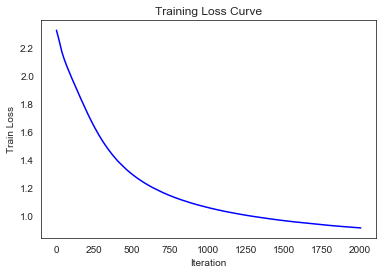

In [81]:
plt.plot(range(len(mlp.loss_curve_)), mlp.loss_curve_, c='blue')
plt.title('Training Loss Curve')
plt.xlabel('Iteration')
plt.ylabel('Train Loss')

In [82]:
# Adjust hidden layer parameters.
mlp1 = MLPClassifier(
    hidden_layer_sizes=(5,2,), random_state=15, max_iter=5000, alpha=0.01)
mlp1.fit(X_train_tfidf, y_train)

MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(5, 2), learning_rate='constant',
              learning_rate_init=0.001, max_iter=5000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=15, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [83]:
# Find accuracy score.
mlp1.score(X_train_tfidf, y_train)

0.8973384030418251

In [84]:
# Cross-validation.
cross_val_score(mlp1, X_train_tfidf, y_train, cv=5)

array([0.21818182, 0.23148148, 0.19811321, 0.26470588, 0.19      ])

Text(0, 0.5, 'Train Loss')

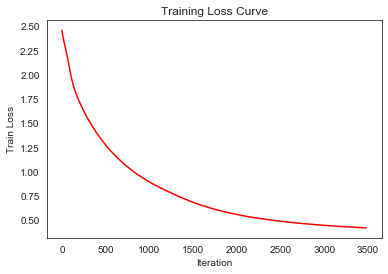

In [85]:
plt.plot(range(len(mlp1.loss_curve_)), mlp1.loss_curve_, c='red')
plt.title('Training Loss Curve')
plt.xlabel('Iteration')
plt.ylabel('Train Loss')

In [86]:
# Adjust hidden layer parameters.
mlp2 = MLPClassifier(
    hidden_layer_sizes=(5,2,), random_state=15, max_iter=5000, alpha=0.05)
mlp2.fit(X_train_tfidf, y_train)

MLPClassifier(activation='relu', alpha=0.05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(5, 2), learning_rate='constant',
              learning_rate_init=0.001, max_iter=5000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=15, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [87]:
# Find accuracy score.
mlp2.score(X_train_tfidf, y_train)

0.8954372623574145

In [88]:
# Cross-validation.
cross_val_score(mlp2, X_train_tfidf, y_train, cv=5)

array([0.2       , 0.21296296, 0.22641509, 0.25490196, 0.15      ])

Text(0, 0.5, 'Train Loss')

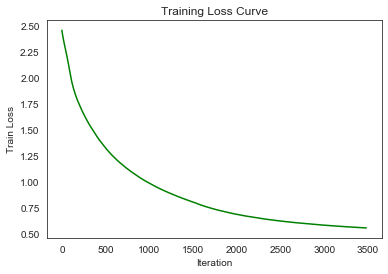

In [89]:
plt.plot(range(len(mlp2.loss_curve_)), mlp2.loss_curve_, c='green')
plt.title('Training Loss Curve')
plt.xlabel('Iteration')
plt.ylabel('Train Loss')

Text(0, 0.5, 'Train Loss')

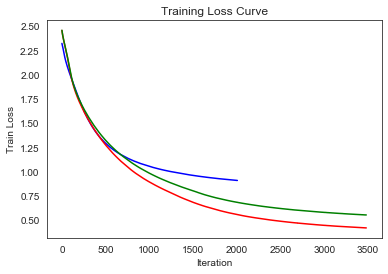

In [90]:
plt.plot(range(len(mlp.loss_curve_)), mlp.loss_curve_, c='blue')
plt.plot(range(len(mlp1.loss_curve_)), mlp1.loss_curve_, c='red')
plt.plot(range(len(mlp2.loss_curve_)), mlp2.loss_curve_, c='green')
plt.title('Training Loss Curve')
plt.xlabel('Iteration')
plt.ylabel('Train Loss')
#plt.show()